# Meta Reinforcement Learning with A3C - Rainbow Gridworld

This iPython notebook includes an implementation of the [A3C algorithm capable of Meta-RL](https://arxiv.org/pdf/1611.05763.pdf).

For more information see the accompanying [Medium post](https://medium.com/p/b15b592a2ddf).

In [17]:
import threading
import multiprocessing
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.contrib.slim as slim
from tensorflow.examples.tutorials.mnist import input_data

import gym

import scipy.signal
%matplotlib inline
from helper import *

from random import choice
from time import sleep
from time import time


### Actor-Critic Network

In [19]:
class AC_Network():
    def __init__(self,a_size,scope,trainer):
        with tf.variable_scope(scope):
            #Input and visual encoding layers
            self.state = tf.placeholder(shape=[None,5,5,3],dtype=tf.float32)
            self.conv = slim.fully_connected(slim.flatten(self.state),64,activation_fn=tf.nn.elu)
            self.prev_rewards = tf.placeholder(shape=[None,1],dtype=tf.float32)
            self.prev_actions = tf.placeholder(shape=[None],dtype=tf.int32)
            self.timestep = tf.placeholder(shape=[None,1],dtype=tf.float32)
            self.prev_actions_onehot = tf.one_hot(self.prev_actions,a_size,dtype=tf.float32)

            hidden = tf.concat([slim.flatten(self.conv),self.prev_rewards,self.prev_actions_onehot,self.timestep],1)
            
            #Recurrent network for temporal dependencies
            lstm_cell = tf.contrib.rnn.BasicLSTMCell(48,state_is_tuple=True)
            c_init = np.zeros((1, lstm_cell.state_size.c), np.float32)
            h_init = np.zeros((1, lstm_cell.state_size.h), np.float32)
            self.state_init = [c_init, h_init]
            c_in = tf.placeholder(tf.float32, [1, lstm_cell.state_size.c])
            h_in = tf.placeholder(tf.float32, [1, lstm_cell.state_size.h])
            self.state_in = (c_in, h_in)
            rnn_in = tf.expand_dims(hidden, [0])
            step_size = tf.shape(self.prev_rewards)[:1]
            state_in = tf.contrib.rnn.LSTMStateTuple(c_in, h_in)
            lstm_outputs, lstm_state = tf.nn.dynamic_rnn(
                lstm_cell, rnn_in, initial_state=state_in, sequence_length=step_size,
                time_major=False)
            lstm_c, lstm_h = lstm_state
            self.state_out = (lstm_c[:1, :], lstm_h[:1, :])
            rnn_out = tf.reshape(lstm_outputs, [-1, 48])
            
            self.actions = tf.placeholder(shape=[None],dtype=tf.int32)
            self.actions_onehot = tf.one_hot(self.actions,a_size,dtype=tf.float32)
                        
            #Output layers for policy and value estimations
            self.policy = slim.fully_connected(rnn_out,a_size,
                activation_fn=tf.nn.softmax,
                weights_initializer=normalized_columns_initializer(0.01),
                biases_initializer=None)
            self.value = slim.fully_connected(rnn_out,1,
                activation_fn=None,
                weights_initializer=normalized_columns_initializer(1.0),
                biases_initializer=None)
            
            #Only the worker network need ops for loss functions and gradient updating.
            if scope != 'global':
                self.target_v = tf.placeholder(shape=[None],dtype=tf.float32)
                self.advantages = tf.placeholder(shape=[None],dtype=tf.float32)
                
                self.responsible_outputs = tf.reduce_sum(self.policy * self.actions_onehot, [1])

                #Loss functions
                self.value_loss = 0.5 * tf.reduce_sum(tf.square(self.target_v - tf.reshape(self.value,[-1])))
                self.entropy = - tf.reduce_sum(self.policy * tf.log(self.policy + 1e-7))
                self.policy_loss = -tf.reduce_sum(tf.log(self.responsible_outputs + 1e-7)*self.advantages)
                self.loss = 0.5 *self.value_loss + self.policy_loss - self.entropy * 0.05

                #Get gradients from local network using local losses
                local_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope)
                self.gradients = tf.gradients(self.loss,local_vars)
                self.var_norms = tf.global_norm(local_vars)
                grads,self.grad_norms = tf.clip_by_global_norm(self.gradients,50.0)
                
                #Apply local gradients to global network
                global_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'global')
                self.apply_grads = trainer.apply_gradients(zip(grads,global_vars))

### Worker Agent

In [20]:
class Worker():
    def __init__(self,game,name,a_size,trainer,model_path,global_episodes):
        self.name = "worker_" + str(name)
        self.number = name        
        self.model_path = model_path
        self.trainer = trainer
        self.global_episodes = global_episodes
        self.increment = self.global_episodes.assign_add(1)
        self.episode_rewards = []
        self.episode_lengths = []
        self.episode_mean_values = []
        self.summary_writer = tf.summary.FileWriter("train_"+str(self.number))

        #Create the local copy of the network and the tensorflow op to copy global paramters to local network
        self.local_AC = AC_Network(a_size,self.name,trainer)
        self.update_local_ops = update_target_graph('global',self.name)        
        self.env = game
        
    def train(self,rollout,sess,gamma,bootstrap_value):
        rollout = np.array(rollout)
        states = rollout[:,0]
        actions = rollout[:,1]
        rewards = rollout[:,2]
        timesteps = rollout[:,3]
        prev_rewards = [0] + rewards[:-1].tolist()
        prev_actions = [0] + actions[:-1].tolist()
        values = rollout[:,5]
        
        self.pr = prev_rewards
        self.pa = prev_actions
        # Here we take the rewards and values from the rollout, and use them to 
        # generate the advantage and discounted returns. 
        # The advantage function uses "Generalized Advantage Estimation"
        self.rewards_plus = np.asarray(rewards.tolist() + [bootstrap_value])
        discounted_rewards = discount(self.rewards_plus,gamma)[:-1]
        self.value_plus = np.asarray(values.tolist() + [bootstrap_value])
        advantages = rewards + gamma * self.value_plus[1:] - self.value_plus[:-1]
        advantages = discount(advantages,gamma)

        # Update the global network using gradients from loss
        # Generate network statistics to periodically save
        rnn_state = self.local_AC.state_init
        feed_dict = {self.local_AC.target_v:discounted_rewards,
            self.local_AC.state:np.stack(states,axis=0),
            self.local_AC.prev_rewards:np.vstack(prev_rewards),
            self.local_AC.prev_actions:prev_actions,
            self.local_AC.actions:actions,
            self.local_AC.timestep:np.vstack(timesteps),
            self.local_AC.advantages:advantages,
            self.local_AC.state_in[0]:rnn_state[0],
            self.local_AC.state_in[1]:rnn_state[1]}
        v_l,p_l,e_l,g_n,v_n,_ = sess.run([self.local_AC.value_loss,
            self.local_AC.policy_loss,
            self.local_AC.entropy,
            self.local_AC.grad_norms,
            self.local_AC.var_norms,
            self.local_AC.apply_grads],
            feed_dict=feed_dict)
        return v_l / len(rollout),p_l / len(rollout),e_l / len(rollout), g_n,v_n
        
    def work(self,gamma,sess,coord,saver,train):
        episode_count = sess.run(self.global_episodes)
        total_steps = 0
        print("Starting worker " + str(self.number))
        with sess.as_default(), sess.graph.as_default():                 
            while not coord.should_stop():
                sess.run(self.update_local_ops)
                episode_buffer = []
                episode_values = []
                episode_frames = []
                episode_reward = 0
                episode_step_count = 0
                d = False
                r = 0
                a = 0
                t = 0
                reward_color = [np.random.uniform(),np.random.uniform(),np.random.uniform()]
                #reward_color = [1,0,0]
                s,s_big = self.env.reset(reward_color)
                rnn_state = self.local_AC.state_init
                
                while d == False:
                    #Take an action using probabilities from policy network output.
                    a_dist,v,rnn_state_new = sess.run([self.local_AC.policy,self.local_AC.value,self.local_AC.state_out], 
                        feed_dict={
                        self.local_AC.state:[s],
                        self.local_AC.prev_rewards:[[r]],
                        self.local_AC.timestep:[[t]],
                        self.local_AC.prev_actions:[a],
                        self.local_AC.state_in[0]:rnn_state[0],
                        self.local_AC.state_in[1]:rnn_state[1]})
                    a = np.random.choice(a_dist[0],p=a_dist[0])
                    a = np.argmax(a_dist == a)
                    
                    rnn_state = rnn_state_new
                    s1,s1_big,r,d,_,_ = self.env.step(a)                        
                    episode_buffer.append([s,a,r,t,d,v[0,0]])
                    episode_values.append(v[0,0])
                    episode_reward += r
                    episode_frames.append(set_image_gridworld(s1_big,reward_color,episode_reward,t))
                    total_steps += 1
                    t += 1
                    episode_step_count += 1
                    s = s1
                    
                    print('\r {}, {}'.format(episode_count, episode_step_count),end='')
                    
                    if episode_step_count > 100:
                        d = True
                                            
                self.episode_rewards.append(episode_reward)
                self.episode_lengths.append(episode_step_count)
                self.episode_mean_values.append(np.mean(episode_values))
                
                # Update the network using the experience buffer at the end of the episode.
                if len(episode_buffer) != 0 and train == True:
                    v_l,p_l,e_l,g_n,v_n = self.train(episode_buffer,sess,gamma,0.0)
            
                    
                # Periodically save gifs of episodes, model parameters, and summary statistics.
                if episode_count % 50 == 0 and episode_count != 0:
                    if episode_count % 500 == 0 and self.name == 'worker_0' and train == True:
                        saver.save(sess,self.model_path+'/model-'+str(episode_count)+'.cptk')
                        print("Saved Model")

                    if self.name == 'worker_0' and episode_count % 50 == 0:
                        time_per_step = 0.25
                        self.images = np.array(episode_frames)
                        make_gif(self.images,'./frames/image'+str(episode_count)+'.gif',
                            duration=len(self.images)*time_per_step,true_image=True)

                        
                    mean_reward = np.mean(self.episode_rewards[-50:])
                    mean_length = np.mean(self.episode_lengths[-50:])
                    mean_value = np.mean(self.episode_mean_values[-50:])
                    summary = tf.Summary()
                    summary.value.add(tag='Perf/Reward', simple_value=float(mean_reward))
                    summary.value.add(tag='Perf/Length', simple_value=float(mean_length))
                    summary.value.add(tag='Perf/Value', simple_value=float(mean_value))
                    if train == True:
                        summary.value.add(tag='Losses/Value Loss', simple_value=float(v_l))
                        summary.value.add(tag='Losses/Policy Loss', simple_value=float(p_l))
                        summary.value.add(tag='Losses/Entropy', simple_value=float(e_l))
                        summary.value.add(tag='Losses/Grad Norm', simple_value=float(g_n))
                        summary.value.add(tag='Losses/Var Norm', simple_value=float(v_n))
                    self.summary_writer.add_summary(summary, episode_count)

                    self.summary_writer.flush()
                if self.name == 'worker_0':
                    sess.run(self.increment)
                episode_count += 1

In [21]:
gamma = .95 # discount rate for advantage estimation and reward discounting
a_size = 4 
load_model = False
train = True
model_path = './model_meta_grid'

Starting worker 0
Starting worker 4
Starting worker 7
Starting worker 3
Starting worker 5
Starting worker 11
Starting worker 6
Starting worker 1
Starting worker 9Starting worker 8

Starting worker 10
Starting worker 2
 0, 36

Exception in thread Thread-110:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-22-dd53fac12a95>", line 31, in <lambda>
    worker_work = lambda: worker.work(gamma,sess,coord,saver,train)
  File "<ipython-input-20-9289afffbfb9>", line 91, in work
    self.local_AC.state_in[1]:rnn_state[1]})
  File "/home/wonchul/.virtualenvs/p3/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 887, in run
    run_metadata_ptr)
  File "/home/wonchul/.virtualenvs/p3/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1033, in _run
    raise RuntimeError('Attempted to use a closed Session.')
RuntimeError: Attempted to use a closed Session.

Exception in thread Thread-100:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootst

KeyboardInterrupt: 

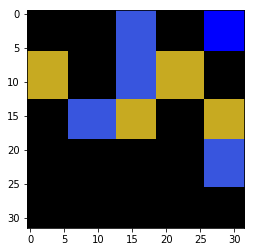

In [22]:
tf.reset_default_graph()

if not os.path.exists(model_path):
    os.makedirs(model_path)
    
if not os.path.exists('./frames'):
    os.makedirs('./frames')
    
with tf.device("/cpu:0"): 
    global_episodes = tf.Variable(0,dtype=tf.int32,name='global_episodes',trainable=False)
    trainer = tf.train.AdamOptimizer(learning_rate=1e-3)
    master_network = AC_Network(a_size,'global',None) # Generate global network
    num_workers = multiprocessing.cpu_count() # Set workers ot number of available CPU threads
    workers = []
    # Create worker classes
    for i in range(num_workers):
        workers.append(Worker(gameEnv(partial=False,size=5,goal_color=[np.random.uniform(),np.random.uniform(),np.random.uniform()]),i,a_size,trainer,model_path,global_episodes))
    saver = tf.train.Saver(max_to_keep=5)

with tf.Session() as sess:
    coord = tf.train.Coordinator()
    if load_model == True:
        print('Loading Model...')
        ckpt = tf.train.get_checkpoint_state(model_path)
        saver.restore(sess,ckpt.model_checkpoint_path)
    else:
        sess.run(tf.global_variables_initializer())
        
    worker_threads = []
    for worker in workers:
        worker_work = lambda: worker.work(gamma,sess,coord,saver,train)
        thread = threading.Thread(target=(worker_work))
        thread.start()
        worker_threads.append(thread)
    coord.join(worker_threads)

In [ ]:
|